In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
import re
from pylab import rcParams
from sklearn import linear_model
%matplotlib inline

In [20]:
rcParams['figure.figsize'] = 10,10
rcParams['axes.linewidth'] = 4.0
rcParams['savefig.dpi'] = 500
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [21]:
file="/home/cad234/Desktop/SRI_Binding3.txt"
df =pd.read_csv(file, header=None, sep='\t', engine='python', )
df.columns = ["Compound", "Conf","DAT Uptake", "Error", "Emax"]

In [22]:
def rmse(pred, tar):
    return np.sqrt(((pred - tar) ** 2).mean())

def convertAffinity(x):
    return .593*np.log(x*1e-9)

# Single Linear Regression

In [23]:
df['Exp dG'] = df['DAT Uptake'].apply(convertAffinity)

df['Calc dG']=''
dG_list=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+".dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA TOTAL", line):
            dG_total = line.split()
            dG_list.append(dG_total[2])
df['Calc dG'] = dG_list
df['Calc dG'] = pd.to_numeric(df['Calc dG'])

In [24]:
X = sm.add_constant(df["Calc dG"])
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)
b = regr.intercept_
m = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.76
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           1.47e-08
Time:                        11:04:25   Log-Likelihood:                -17.764
No. Observations:                  30   AIC:                             39.53
Df Residuals:                      28   BIC:                             42.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9683      1.263     -0.767      0.4

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RMSD is: 24.231027508765024


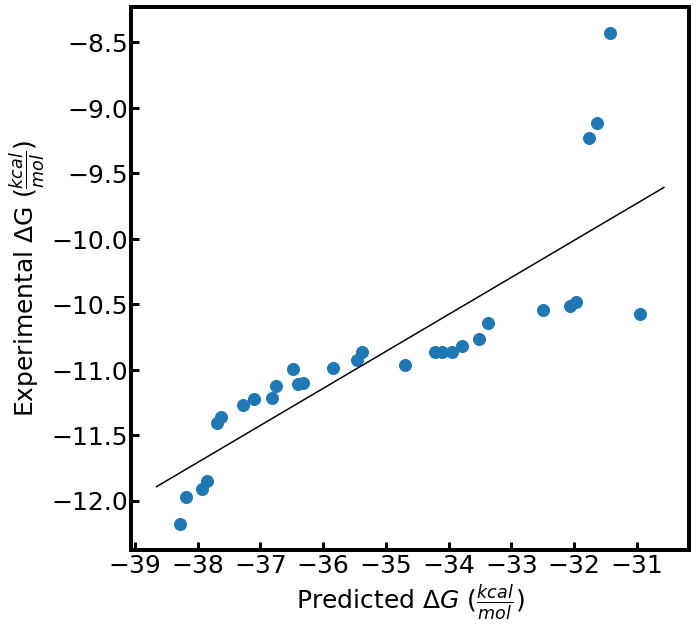

In [25]:
X=df["Calc dG"]
Y=df["Exp dG"]

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0')
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='k')
plt.xlabel(r'Predicted $\Delta G \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
# Save figure
#plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')
#plt.savefig("Correlation_gbsa1.png", format='png', transparent=True, bbox_inches='tight')

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

# Single Linear Regression Corrected

In [26]:
def correctdG(Y):
    return m * Y + b # y=mx+b

In [27]:
df['Correct dG'] = df["Calc dG"].apply(correctdG)

In [28]:
X = sm.add_constant(df["Correct dG"])
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)
b = regr.intercept_
m = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)


                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.76
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           1.47e-08
Time:                        11:05:13   Log-Likelihood:                -17.764
No. Observations:                  30   AIC:                             39.53
Df Residuals:                      28   BIC:                             42.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.776e-15      1.386   1.28e-15      1.0

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RMSD is: 0.4374513599727066


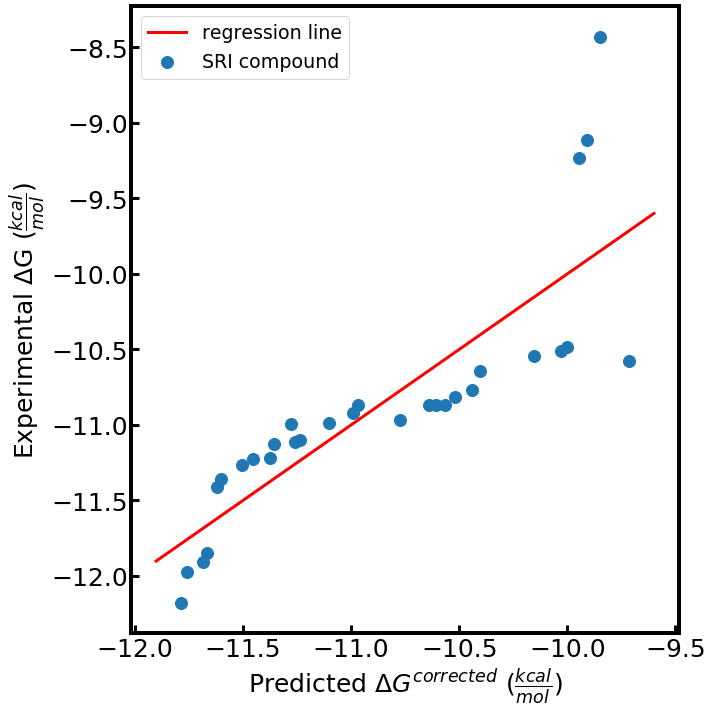

In [49]:
X=df["Correct dG"]
Y=df["Exp dG"]

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='r', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.0, -9.0, 0.5), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
#plt.title("Single Linear Regression", fontsize=25, pad="10")
plt.tight_layout()
# Save figure
plt.savefig("Correlation_gbsa2.png", format='png', transparent=True, bbox_inches='tight')

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

# Multiple Linear Regression 

In [30]:
dG_gas=[]
dG_solv=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+".dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA G gas", line):
            dG_gas_tmp = line.split()
            dG_gas.append(dG_gas_tmp[3])
        if re.match(r"DELTA G solv", line):
            dG_solv_tmp = line.split()
            dG_solv.append(dG_solv_tmp[3])
df['dG Gas']= dG_gas
df['dG Solvent']=dG_solv
df['dG Gas'] = pd.to_numeric(df['dG Gas'])
df['dG Solvent'] = pd.to_numeric(df['dG Solvent'])

In [31]:
X = df[['dG Gas','dG Solvent']]
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)

b = regr.intercept_
m1 = regr.coef_[0]
m2 = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              8577.
Date:                Thu, 22 Aug 2019   Prob (F-statistic):                    9.32e-40
Time:                        11:05:36   Log-Likelihood:                         -17.943
No. Observations:                  30   AIC:                                      39.89
Df Residuals:                      28   BIC:                                      42.69
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [32]:
def correctdG2(Y1, Y2):
    return m1 * Y1 + m2 * Y2 + b # y=mx+mx+b

In [33]:
df['Correct dG2'] = df.apply(lambda x: correctdG2(x['dG Gas'], x['dG Solvent']), axis=1)

RMSD is: 0.43396587658427327


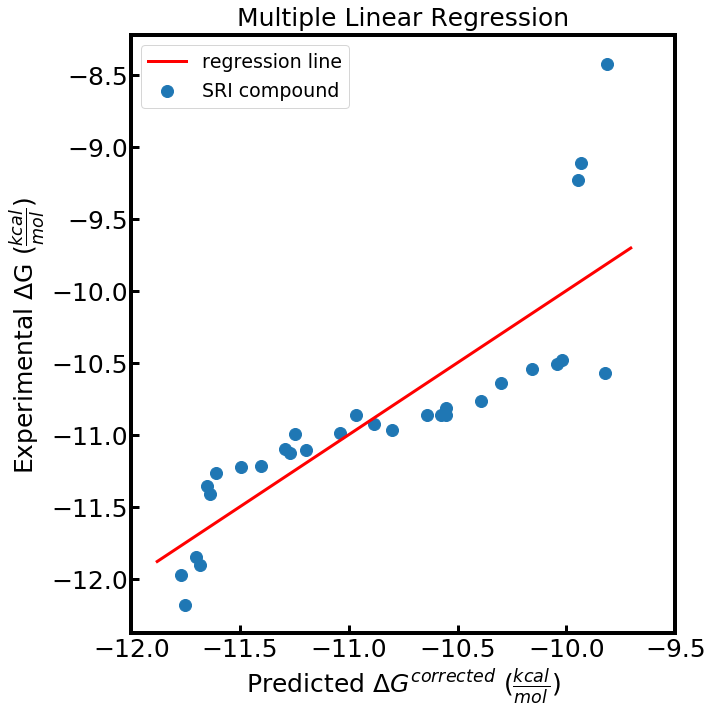

In [35]:
X=df['Correct dG2']
Y=df['Exp dG']

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='red', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.0, -9.0, 0.5), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.title("Multiple Linear Regression", fontsize=25, pad="10")

plt.tight_layout()
# Save figure
#plt.savefig("Correlation2.png", format='png', transparent=True)

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

In [36]:
X = sm.add_constant(df['Correct dG2'])
Y=df['Exp dG']

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)

b = regr.intercept_
m1 = regr.coef_[0]
m2 = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     63.21
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           1.17e-08
Time:                        11:06:07   Log-Likelihood:                -17.524
No. Observations:                  30   AIC:                             39.05
Df Residuals:                      28   BIC:                             41.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         9.77e-15      1.370   7.13e-15      

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Multiple Linear Regression: Y-Intercept = 0

In [37]:
X = df[['dG Gas','dG Solvent']]
X['const']=0
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())
print(results.params)

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              8577.
Date:                Thu, 22 Aug 2019   Prob (F-statistic):                    9.32e-40
Time:                        11:06:17   Log-Likelihood:                         -17.943
No. Observations:                  30   AIC:                                      39.89
Df Residuals:                      28   BIC:                                      42.69
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/Python-3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encounter

In [38]:
def correctdG2(Y1, Y2):
    return 0.305918 * Y1 + 0.298198 * Y2 # y=mx+mx+b

In [39]:
df['test dG2'] = df.apply(lambda x: correctdG2(x['dG Gas'], x['dG Solvent']), axis=1)

RMSD is: 0.44006059081554416


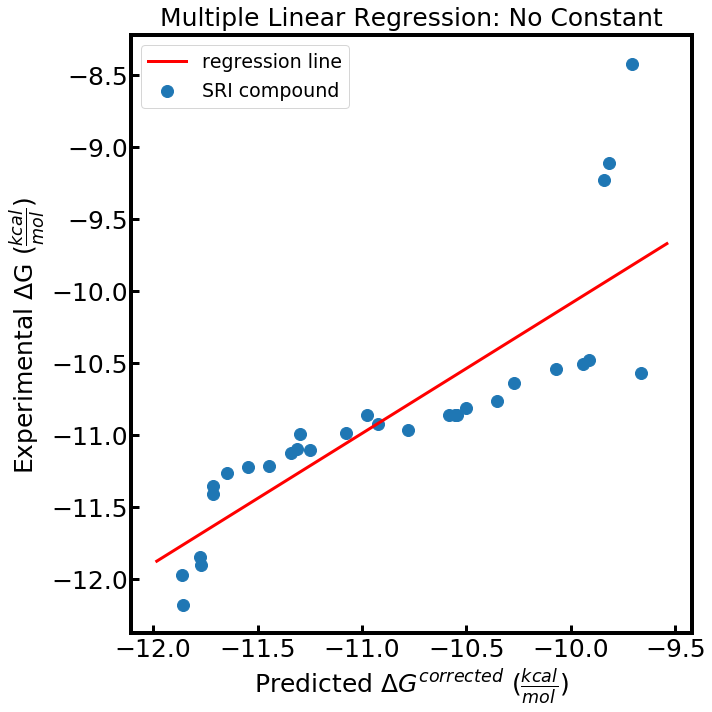

In [43]:
X=df['test dG2']
Y=df['Exp dG']

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='red', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.0, -9.0, 0.5), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.title("Multiple Linear Regression: No Constant", fontsize=25, pad="10")

plt.tight_layout()
# Save figure
#plt.savefig("Correlation2.png", format='png', transparent=True)

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

In [44]:
X = sm.add_constant(df['test dG2'])
Y=df['Exp dG']

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)

b = regr.intercept_
m1 = regr.coef_[0]
m2 = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     63.05
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           1.20e-08
Time:                        11:11:35   Log-Likelihood:                -17.551
No. Observations:                  30   AIC:                             39.10
Df Residuals:                      28   BIC:                             41.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0653      1.238     -0.861      0.3

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Testing code

In [47]:
export_csv = df.to_csv(r'/home/cad234/projects/SRI/ipn/exported_df_gbsa.csv')

In [ ]:
dG_gas=[]
dG_solv=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+".dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA G gas", line):
            dG_gas_tmp = line.split()
            dG_gas.append(dG_gas_tmp[3])
        if re.match(r"DELTA G solv", line):
            dG_solv_tmp = line.split()
            dG_solv.append(dG_solv_tmp[3])
df['dG Gas']= dG_gas
df['dG Solvent']=dG_solv


In [45]:
df

,Compound,Conf,DAT Uptake,Error,Emax,Exp dG,Calc dG,Correct dG,dG Gas,dG Solvent,Correct dG2,test dG2
0,29070,10-1,174.0,58.0,66,-9.229577,-31.7621,-9.945197,-47.7438,15.9817,-9.947053,-9.839977
1,29072,2-2,212.0,49.0,71,-9.112441,-31.6346,-9.909162,-49.7061,18.0715,-9.934170,-9.817106
2,29153,7-3,20.0,1.0,73,-10.512427,-32.0638,-10.030466,-49.2327,17.1689,-10.041542,-9.941437
3,29155,18-1,10.0,1.0,74,-10.923464,-35.4649,-10.991713,-44.7270,9.2621,-10.884515,-10.920855
4,29212,14-5,672.0,204.0,67,-8.428313,-31.4190,-9.848228,-43.6246,12.2056,-9.814276,-9.705865
5,29213,8-2,16.0,4.0,81,-10.644752,-33.3762,-10.401387,-41.2740,7.8978,-10.301902,-10.271351
6,29338,14-4,9.0,1.5,71,-10.985942,-35.8471,-11.099733,-50.3124,14.4653,-11.042827,-11.077945
7,29554,18-2,11.0,1.0,71,-10.866945,-35.3836,-10.968735,-54.7986,19.4150,-10.968363,-10.974364
8,29577,17-2,4.4,0.8,70,-11.410305,-37.6873,-11.619825,-61.2895,23.6022,-11.638945,-11.711432
9,29776,3-1,19.0,4.0,69,-10.542844,-32.4920,-10.151488,-49.6182,17.1262,-10.157617,-10.072102


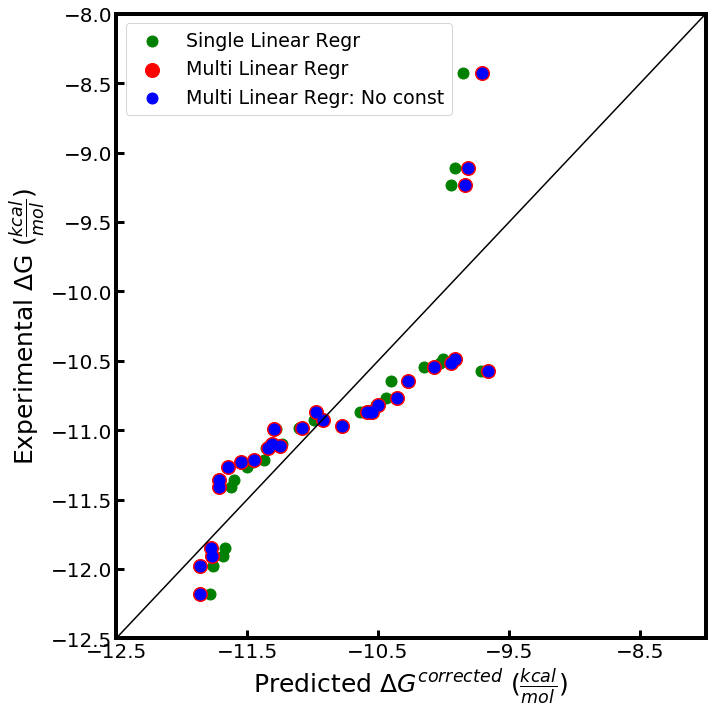

In [93]:
# Scatter plot
Y=df["Exp dG"]
plt.scatter(df["Correct dG"], Y, s=11**2, c='green', label="Single Linear Regr") # Single Linear Regression
plt.scatter(df['Correct dG2'], Y, s=14**2, c='red', label="Multi Linear Regr") # Multi Linear Regression
plt.scatter(df['test dG2'], Y, s=11**2, c='blue', label="Multi Linear Regr: No const") # Multi Linear Regression: No constant

plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.5, -8.0, 1.0), fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.xlim([-12.5,-8.0])
plt.ylim([-12.5,-8.0])

#Plot diagonal line
ident=[-12.5,-8.0]
plt.plot(ident,ident, color='k')

plt.tight_layout()
# Save figure
#plt.savefig("Correlation2.png", format='png', transparent=T